In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install timm

In [3]:
import sys
sys.path.append('drive/MyDrive/ai/final/petfinder-pawpularity-score')
### <디렉토리 설정하는 곳> (검색용) ################################################################################################
### 지금 위의 코드는
### 이 코드파일(ai_final_loss_plot.ipynb)과 함께 다른 데이터셋 관련파일들(test, train, sample_submission.csv, test.csv, train.csv)을 
### 구글드라이브 안의 /ai/final/petfinder-pawpularity-score 디렉토리에 넣어줘야, 코드가 돌아가도록 되어있다.
###
### 위에서 말한 코드파일과 데이터셋 관련 파일들의 위치를 바꾸고 싶으면, 
### 위의 sys.path.append() 안의 인자를 'drive/MyDrive/(구글 드라이브 내의 디렉토리 주소)' 로 바꿔주면 된다.
####################################################################################################################################

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

import cv2
from os import path
from PIL import Image
import torch.utils.data as data
from torchvision import models, transforms
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import h5py
import timm

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

In [5]:
class args:
### <배치크기, 에폭수 설정하는 곳 (검색용)> ######################
### 지금은 batch_size 값 32, 에폭수 10으로 되어있다. 
##################################################################

    seed = 22
    batch_size = 32
    epochs = 10
    image_size = 384  # scale shorter end of image to this size and centre crop
    central_fraction = 0.875  # only take this much of the centre when scaling and centre cropping
    load_img = False # whether load img or not
    workers = 2
    feature_extract = True

def seed_torch(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print("seed: ", seed)

seed_torch(args.seed)

seed:  22


In [6]:
dir_path = 'drive/MyDrive/ai/final/petfinder-pawpularity-score'
### <디렉토리 설정하는 곳> (검색용) ################################################################################################
### 지금 위의 코드는
### 이 코드파일(ai_final_loss_plot.ipynb)과 함께 다른 데이터셋 관련파일들(test, train, sample_submission.csv, test.csv, train.csv)을 
### 구글드라이브 안의 /ai/final/petfinder-pawpularity-score 디렉토리에 넣어줘야, 코드가 돌아가도록 되어있다.
###
### 위에서 말한 코드파일과 데이터셋 관련 파일들의 위치를 바꾸고 싶으면, 
### 위의 sys.path.append() 안의 인자를 'drive/MyDrive/(구글 드라이브 내의 디렉토리 주소)' 로 바꿔주면 된다.
####################################################################################################################################

cached_dir = path.join(dir_path, 'cached_data')
train_img_dir = path.join(dir_path, 'train')
test_img_dir = path.join(dir_path, 'test')

df_train = pd.read_csv(path.join(dir_path, 'train.csv'))
df_test = pd.read_csv(path.join(dir_path, 'test.csv'))

train_img_paths = [path.join(train_img_dir, f"{img_id}.jpg") for img_id in df_train["Id"].values]
test_img_paths = [path.join(test_img_dir, f"{img_id}.jpg") for img_id in df_test["Id"].values]

In [7]:
property_names = [col for col in df_train.columns if col not in ['Id','Pawpularity']]
property_names # 12 properties

# train metda data
train_meta_X = df_train[property_names]
train_Y = df_train['Pawpularity']

# test metda data
test_id = df_test['Id']
test_meta_X = df_test.drop('Id',axis=1)
test_meta_X.shape

(8, 12)

In [8]:
class PawpularDataset(data.Dataset):
    def __init__(self, image_data, meta_features, labels, img_paths, augmentations=None):
        super(PawpularDataset, self).__init__()
        self.load_img = False
        self.image_data = image_data
        self.meta_features = meta_features
        self.labels = labels
        self.augmentations = augmentations
        self.image_paths = img_paths
        if self.augmentations is not None:
            self.load_img = True


    def __getitem__(self, item):
        if self.load_img:
            image = cv2.imread(self.image_paths[item])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            augmented = self.augmentations(image=image)["image"]
            image = np.transpose(augmented, (2, 0, 1)).astype(np.float32)
        else:
            image = self.image_data[item]

        meta = self.meta_features[item]
        label = self.labels[item]
        return image.astype('float32'), meta.astype('float32'), label

    def __len__(self):
        return len(self.labels)


def get_loader(split, features, meta_data, labels, img_paths=[], batch_size=args.batch_size, augmentations=None):
    """ Returns a data loader for the desired split """
    dataset = PawpularDataset(features, meta_data, labels, img_paths, augmentations)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True if split != 'test' else False,  # only shuffle the data in training
        pin_memory=True,
        num_workers=args.workers,
    )
    return loader

In [9]:
import albumentations

def get_augmentations(train=True):
    if train:
        return albumentations.Compose(
            [
                albumentations.Resize(args.image_size, args.image_size, p=1),
                albumentations.HorizontalFlip(p=0.5),
                albumentations.VerticalFlip(p=0.5),
                albumentations.Rotate(limit=180, p=0.7),
                albumentations.ShiftScaleRotate(
                    shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
                ),
                albumentations.HueSaturationValue(
                    hue_shift_limit=0.2, sat_shift_limit=0.2,
                    val_shift_limit=0.2, p=0.5
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=(-0.1, 0.1),
                    contrast_limit=(-0.1, 0.1), p=0.5
                ),
                albumentations.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                ),
            ]
        )
    else:
        return albumentations.Compose(
            [
                albumentations.Resize(args.image_size, args.image_size, p=1),
                albumentations.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                ),
            ]
        )

augmentations = get_augmentations(train=True)
trainval_loader = get_loader('trainval', None, train_meta_X.values, train_Y.values.astype('float32'), train_img_paths,augmentations=augmentations)

augmentations = get_augmentations(train=False)
test_loader = get_loader('test', None, test_meta_X.values, torch.zeros(len(test_img_paths)), test_img_paths, augmentations=augmentations)

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### <인공지능 모델 아키텍처 설정하는 곳> (검색용) ################################################################################################
### 아래에는 다음과 같은 모델 아키텍처를 정의하는 class 코드가 있음.
### 
### PretrainedCNN         - 이미 학습되어있는 "resnet" 모델을 불러오고, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### BaseCNN               - CNN 을 활용한 모델, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### BaseMLP               - MLP 를 활용한 모델, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
### PretrainedTransformer - 이미 학습되어있는 다양한 모델들 중 하나를 불러오고, 마지막 layer에 metadata를 input data로 넣어주도록 고쳐준 모델
###
### 이 아래에 class 중에서 직접 수정해보면 좋은 것은, BaseCNN , BaseMLP class 부분임.
### BaseCNN 은 CNN 실습했을때처럼 수정하면 될 듯
### BaseMLP 는 MLP 실습했을때처럼 수정하면 될 듯
###
### 한편, PretrainedTransformer class 를 활용해도 좋음. 이미 학습되어있는 모델을 불러와서 코드를 돌려볼 수 있음. 자세한 내용은 아래 <모델 고르기> 부분에서 설명함.
####################################################################################################################################



class PretrainedCNN(nn.Module):
    def __init__(self, model_name='resnet', use_meta=False):
        super(PretrainedCNN, self).__init__()
        if model_name == 'resnet':
            self.model = models.resnet152(pretrained=True)
            set_parameter_requires_grad(self.model, feature_extracting=True)
            num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 128)
        self.drop = nn.Dropout(0.5)
        self.use_meta =use_meta
        if self.use_meta:
            self.fc = nn.Linear(128+12, 1)
        else:
            self.fc = nn.Linear(128, 1)
        

    def forward(self, img_data, meta=None, targets=None):
        x = self.model(img_data)
        if self.use_meta:
            x = torch.cat([x, meta], dim=1)
        x = self.fc(self.drop(x)) # [b, o]
        return x



class BaseCNN(nn.Module):
    def __init__(self, num_filters=[], use_meta=False):
        super(BaseCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, num_filters[0], kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(num_filters[0], num_filters[1], kernel_size = 4, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(num_filters[1], num_filters[2], kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(num_filters[2] ,num_filters[3], kernel_size = 8, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(num_filters[3], num_filters[4], kernel_size = 6, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(num_filters[4], num_filters[4], kernel_size = 6, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(12544, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,128)
        )
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        if self.use_meta:
            self.fc = nn.Linear(128+12, 1)
        else:
            self.fc = nn.Linear(128, 1)


    def forward(self, img_data, meta=None, targets=None):
        o = self.conv(self.drop(img_data)) # [b, 1, m]
        if self.use_meta:
            o = torch.cat([o, meta], dim=1)
        x = self.fc(self.drop(o)) # [b, o]
        return x


class BaseMLP(nn.Module):
    def __init__(self, use_meta=False, input_size=args.image_size):
        super(BaseMLP, self).__init__()
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        self.lin = nn.Sequential(
            nn.Linear(input_size*input_size, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(3),
            nn.Dropout(0.5),
            nn.Linear(512,128)
        )
        if self.use_meta:
            self.fc = nn.Linear((128*3)+12, 1)
        else:
            self.fc = nn.Linear(128*3, 1)


    def forward(self, img_data, meta=None, targets=None):
        b, c, img_size, _ = img_data.shape
        img_data = img_data.view(b, c, img_size*img_size)
        o = self.lin(self.drop(img_data)) # [b, 3, 128]
        o = o.view(b, -1)
        if self.use_meta:
            o = torch.cat([o, meta], dim=1)
        x = self.fc(self.drop(o)) # [b, o]
        return x


class PretrainedTransformer(nn.Module):
    def __init__(self, model_name='', use_meta=False, pretrained=True):
        super(PretrainedTransformer, self).__init__()
        # fc
        self.use_meta = use_meta
        self.drop = nn.Dropout(0.5)
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        set_parameter_requires_grad(self.model, feature_extracting=True)
        num_features = self.model.num_features

        if self.use_meta:
            self.fc = nn.Linear(num_features+12, 1)
        else:
            self.fc = nn.Linear(num_features, 1)


    def forward(self, img_data, meta=None, targets=None):
        x = self.model(img_data)
        if self.use_meta:
            x = torch.cat([x, meta], dim=1)
        x = self.fc(self.drop(x)) # [b, o]
        return x




torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [11]:
import matplotlib.pyplot as plt ##5
test_loss_record = [] ##5
mse = nn.MSELoss()  ##


def train(model, optimizer, train_loader, val_loader, train=True, val=False, epoch=0, grad_clip=False):
    labels, preds = [], []
    if train:
        #mse = nn.MSELoss() -> 이건 밖으로 빼서 전역변수로 만들었음 ##
        train_loader = tqdm(train_loader, desc='{} E{:03d}'.format('train', epoch), ncols=0)
        model.train()
        for i, (img, meta_feature, label) in enumerate(train_loader):
            img = img.cuda().float()
            meta_feature = meta_feature.cuda()
            label = label.cuda()
            pred = model(img, meta_feature, label)

            # loss = criterion(pred , label.view(-1,1))
            loss = mse(pred, label.view(-1, 1))

            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()

            num = 10
            if i % num == 0:
                rmse_loss = pow(loss.item() , 0.5)
                print("\tTrain Epoch:{} \tTrain Loss(RMSE): {:.6f}".format(epoch, rmse_loss)) ##
                test_loss_record.append(rmse_loss)
    
    if val:
        model.eval()
        val_loader = tqdm(val_loader, desc='{} E{:03d}'.format('val', epoch), ncols=0)
        for i, (img, meta_feature, label) in enumerate(val_loader):
            img = img.cuda().float()
            pred = model(img, meta_feature, None)

            labels.append(label.detach().cpu())
            preds.append(pred.detach().cpu())

        labels = torch.cat(labels, dim=0).numpy() # [num_seg]
        preds = torch.cat(preds, dim=0).numpy() # [num_seg]

    return labels, preds

In [12]:
### <학습된 모델 확인하기> (검색용) ######################
### 사용할 수 있는 이미 학습된 모델들을 아래 출력해줌
############################################################
timm.list_models()[:]

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

In [13]:
import torch.optim as optim

name = 'tf_efficientnet_b0_ns'

### <모델 고르기> (검색용) ##########################################################################################################
### 학습에 사용할 인공지능 모델을 골라준다.
### 아래 주석을 해제하여 사용
### 
### PretrainedTransformer 사용하는 방법
### 1. 아래 "model = PretrainedTransformer.." 가 있는 줄의 주석을 해제한다.
### 2. 아까 위에서 <학습된 모델 확인하기>에서 출력된 모델 중 하나를 고른다.
### 3. 아래 (학습된 모델 이름) 에 넣어준다.
#####################################################################################################################################
model = PretrainedCNN(use_meta = True)                                          ### PretrainedCNN(resnet모델) 을 사용하는 경우
#model = BaseCNN(use_meta = True)                                                ### BaseCNN 을 사용하는 경우
#model = BaseMLP(use_meta = True)                                                ### BaseMLP 를 사용하는 경우
#model = PretrainedTransformer(model_name='(학습된 모델 이름)', use_meta = True) ### PretrainedTransformer 을 사용하는 경우 


params_to_update = model.parameters()
print("Params to learn:")
if args.feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

### <optimizer 설정하는 곳> (검색용) ########################################################################
### 지금은 optim.Adam 으로 설정되어있음. optim.Adam 대신 다른 optimizer 알고리즘으로 바꿀수 있다.
###
### 다른 optimizer들 : optim.Adadelta , optim.Adagrad, optim.AdamW 등등
### 다른 optimizer로 바꾸려면, 해당 optimizer 알고리즘에 필요한 인자들을 알맞게 넣어줘야 한다. 
### 인자를 넣는 형식 등 자세한 사용법은 https://pytorch.org/docs/stable/optim.html 에 가서 
### Algorithms 부분 밑에 알고리즘을 클릭해서 들어가면 알 수 있음.
####################################################################################################
learning_rate = 1e-2
optimizer = optim.Adam(params_to_update, lr=learning_rate, amsgrad=False)
model = nn.DataParallel(model).cuda()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Params to learn:
	 model.fc.weight
	 model.fc.bias
	 fc.weight
	 fc.bias


In [14]:
##5  추가한 코드셀
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    #correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += mse(output, label).item()
    
    test_loss /= (len(test_loader.dataset) / args.batch_size)

    return test_loss

In [15]:
# # Train & val the model
best_score = 0
epochs = args.epochs



for epoch in range(epochs):
    labels, pred = train(model, optimizer, trainval_loader, None, train=True, val=False, epoch=epoch, grad_clip=True)

    torch.save({"model": model.state_dict()}, "efficient_model.pth")

train E000:   0% 1/310 [00:08<46:08,  8.96s/it]

	Train Epoch:0 	Train Loss(RMSE): 42.422983


train E000:   4% 11/310 [00:21<08:09,  1.64s/it]

	Train Epoch:0 	Train Loss(RMSE): 20.371416


train E000:   7% 21/310 [00:34<07:41,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 21.922357


train E000:  10% 31/310 [00:47<07:22,  1.58s/it]

	Train Epoch:0 	Train Loss(RMSE): 19.565788


train E000:  13% 41/310 [01:00<07:10,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 18.204065


train E000:  16% 51/310 [01:13<06:53,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 22.969805


train E000:  20% 61/310 [01:26<06:41,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 18.646427


train E000:  23% 71/310 [01:39<06:20,  1.59s/it]

	Train Epoch:0 	Train Loss(RMSE): 25.819761


train E000:  26% 81/310 [01:52<06:08,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 29.446802


train E000:  29% 91/310 [02:05<05:50,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 24.827314


train E000:  33% 101/310 [02:18<05:36,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 20.509482


train E000:  36% 111/310 [02:31<05:17,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 23.608537


train E000:  39% 121/310 [02:44<05:03,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 33.758705


train E000:  42% 131/310 [02:57<04:45,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 22.486556


train E000:  45% 141/310 [03:10<04:31,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 30.205831


train E000:  49% 151/310 [03:23<04:14,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 19.477177


train E000:  52% 161/310 [03:36<03:59,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 19.860977


train E000:  55% 171/310 [03:48<03:41,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 22.813621


train E000:  58% 181/310 [04:01<03:27,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 19.830683


train E000:  62% 191/310 [04:14<03:10,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 25.075499


train E000:  65% 201/310 [04:27<02:55,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 18.789860


train E000:  68% 211/310 [04:40<02:37,  1.59s/it]

	Train Epoch:0 	Train Loss(RMSE): 16.921927


train E000:  71% 221/310 [04:53<02:22,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 22.764933


train E000:  75% 231/310 [05:06<02:06,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 19.048149


train E000:  78% 241/310 [05:19<01:50,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 17.220432


train E000:  81% 251/310 [05:32<01:34,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 23.083374


train E000:  84% 261/310 [05:45<01:18,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 23.834197


train E000:  87% 271/310 [05:58<01:02,  1.59s/it]

	Train Epoch:0 	Train Loss(RMSE): 19.822165


train E000:  91% 281/310 [06:11<00:46,  1.61s/it]

	Train Epoch:0 	Train Loss(RMSE): 24.415461


train E000:  94% 291/310 [06:24<00:30,  1.59s/it]

	Train Epoch:0 	Train Loss(RMSE): 25.430361


train E000:  97% 301/310 [06:37<00:14,  1.60s/it]

	Train Epoch:0 	Train Loss(RMSE): 18.036041


train E000: 100% 310/310 [06:54<00:00,  1.34s/it]
train E001:   0% 1/310 [00:03<15:36,  3.03s/it]

	Train Epoch:1 	Train Loss(RMSE): 17.986796


train E001:   4% 11/310 [00:16<08:04,  1.62s/it]

	Train Epoch:1 	Train Loss(RMSE): 19.116388


train E001:   7% 21/310 [00:28<07:40,  1.59s/it]

	Train Epoch:1 	Train Loss(RMSE): 26.002096


train E001:  10% 31/310 [00:41<07:27,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 23.782266


train E001:  13% 41/310 [00:54<07:13,  1.61s/it]

	Train Epoch:1 	Train Loss(RMSE): 19.267969


train E001:  16% 51/310 [01:07<06:54,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 26.989138


train E001:  20% 61/310 [01:20<06:35,  1.59s/it]

	Train Epoch:1 	Train Loss(RMSE): 24.403905


train E001:  23% 71/310 [01:33<06:23,  1.61s/it]

	Train Epoch:1 	Train Loss(RMSE): 27.752320


train E001:  26% 81/310 [01:46<06:05,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 23.549016


train E001:  29% 91/310 [01:59<05:51,  1.61s/it]

	Train Epoch:1 	Train Loss(RMSE): 19.260818


train E001:  33% 101/310 [02:12<05:33,  1.59s/it]

	Train Epoch:1 	Train Loss(RMSE): 15.634648


train E001:  36% 111/310 [02:25<05:17,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 22.481909


train E001:  39% 121/310 [02:38<05:01,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.629094


train E001:  42% 131/310 [02:51<04:47,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 20.959064


train E001:  45% 141/310 [03:04<04:28,  1.59s/it]

	Train Epoch:1 	Train Loss(RMSE): 27.105141


train E001:  49% 151/310 [03:17<04:14,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 16.687923


train E001:  52% 161/310 [03:29<03:57,  1.59s/it]

	Train Epoch:1 	Train Loss(RMSE): 26.338856


train E001:  55% 171/310 [03:42<03:42,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 23.086444


train E001:  58% 181/310 [03:55<03:25,  1.59s/it]

	Train Epoch:1 	Train Loss(RMSE): 22.857244


train E001:  62% 191/310 [04:08<03:10,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 24.463681


train E001:  65% 201/310 [04:21<02:54,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.114353


train E001:  68% 211/310 [04:34<02:41,  1.63s/it]

	Train Epoch:1 	Train Loss(RMSE): 25.201100


train E001:  71% 221/310 [04:47<02:22,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 25.536436


train E001:  75% 231/310 [05:00<02:07,  1.61s/it]

	Train Epoch:1 	Train Loss(RMSE): 22.219565


train E001:  78% 241/310 [05:13<01:50,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 23.116090


train E001:  81% 251/310 [05:26<01:34,  1.61s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.874987


train E001:  84% 261/310 [05:39<01:18,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 18.872569


train E001:  87% 271/310 [05:52<01:02,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 12.655581


train E001:  91% 281/310 [06:05<00:46,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 14.220341


train E001:  94% 291/310 [06:18<00:30,  1.61s/it]

	Train Epoch:1 	Train Loss(RMSE): 21.941452


train E001:  97% 301/310 [06:31<00:14,  1.60s/it]

	Train Epoch:1 	Train Loss(RMSE): 18.724597


train E001: 100% 310/310 [06:42<00:00,  1.30s/it]
train E002:   0% 1/310 [00:03<16:24,  3.19s/it]

	Train Epoch:2 	Train Loss(RMSE): 17.640641


train E002:   4% 11/310 [00:16<08:05,  1.62s/it]

	Train Epoch:2 	Train Loss(RMSE): 19.853948


train E002:   7% 21/310 [00:29<07:44,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 14.520454


train E002:  10% 31/310 [00:42<07:29,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 16.313134


train E002:  13% 41/310 [00:55<07:16,  1.62s/it]

	Train Epoch:2 	Train Loss(RMSE): 25.990591


train E002:  16% 51/310 [01:08<06:56,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 21.607699


train E002:  20% 61/310 [01:21<06:43,  1.62s/it]

	Train Epoch:2 	Train Loss(RMSE): 22.372258


train E002:  23% 71/310 [01:34<06:24,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 17.303695


train E002:  26% 81/310 [01:47<06:04,  1.59s/it]

	Train Epoch:2 	Train Loss(RMSE): 18.819476


train E002:  29% 91/310 [02:00<05:51,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 25.010025


train E002:  33% 101/310 [02:13<05:33,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 17.076881


train E002:  36% 111/310 [02:26<05:17,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 21.378775


train E002:  39% 121/310 [02:38<05:01,  1.59s/it]

	Train Epoch:2 	Train Loss(RMSE): 23.575413


train E002:  42% 131/310 [02:51<04:46,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 24.970873


train E002:  45% 141/310 [03:04<04:29,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 22.160104


train E002:  49% 151/310 [03:17<04:15,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 20.656705


train E002:  52% 161/310 [03:30<03:57,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 17.566216


train E002:  55% 171/310 [03:43<03:43,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 17.286887


train E002:  58% 181/310 [03:56<03:25,  1.59s/it]

	Train Epoch:2 	Train Loss(RMSE): 24.467282


train E002:  62% 191/310 [04:09<03:11,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 20.816931


train E002:  65% 201/310 [04:22<02:53,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 23.014662


train E002:  68% 211/310 [04:35<02:39,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 27.107439


train E002:  71% 221/310 [04:48<02:22,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 19.486904


train E002:  75% 231/310 [05:01<02:08,  1.62s/it]

	Train Epoch:2 	Train Loss(RMSE): 25.606953


train E002:  78% 241/310 [05:14<01:50,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 24.881019


train E002:  81% 251/310 [05:27<01:35,  1.62s/it]

	Train Epoch:2 	Train Loss(RMSE): 25.225090


train E002:  84% 261/310 [05:40<01:17,  1.59s/it]

	Train Epoch:2 	Train Loss(RMSE): 19.993606


train E002:  87% 271/310 [05:53<01:02,  1.60s/it]

	Train Epoch:2 	Train Loss(RMSE): 14.809504


train E002:  91% 281/310 [06:06<00:46,  1.59s/it]

	Train Epoch:2 	Train Loss(RMSE): 22.521837


train E002:  94% 291/310 [06:19<00:30,  1.61s/it]

	Train Epoch:2 	Train Loss(RMSE): 19.024351


train E002:  97% 301/310 [06:32<00:14,  1.59s/it]

	Train Epoch:2 	Train Loss(RMSE): 23.976358


train E002: 100% 310/310 [06:42<00:00,  1.30s/it]
train E003:   0% 1/310 [00:03<15:43,  3.05s/it]

	Train Epoch:3 	Train Loss(RMSE): 17.729227


train E003:   4% 11/310 [00:16<08:00,  1.61s/it]

	Train Epoch:3 	Train Loss(RMSE): 21.487802


train E003:   7% 21/310 [00:29<07:42,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 25.115875


train E003:  10% 31/310 [00:41<07:23,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 17.133147


train E003:  13% 41/310 [00:55<07:12,  1.61s/it]

	Train Epoch:3 	Train Loss(RMSE): 21.470748


train E003:  16% 51/310 [01:08<06:56,  1.61s/it]

	Train Epoch:3 	Train Loss(RMSE): 20.731221


train E003:  20% 61/310 [01:21<06:39,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 15.566077


train E003:  23% 71/310 [01:33<06:22,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 17.170668


train E003:  26% 81/310 [01:46<06:06,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 22.199968


train E003:  29% 91/310 [01:59<05:48,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.564967


train E003:  33% 101/310 [02:12<05:35,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 24.431513


train E003:  36% 111/310 [02:25<05:17,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 24.654517


train E003:  39% 121/310 [02:38<05:03,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.873319


train E003:  42% 131/310 [02:51<04:45,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 21.991761


train E003:  45% 141/310 [03:04<04:30,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 24.144286


train E003:  49% 151/310 [03:17<04:13,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 18.372964


train E003:  52% 161/310 [03:30<03:59,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 19.697352


train E003:  55% 171/310 [03:43<03:40,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 25.144320


train E003:  58% 181/310 [03:56<03:26,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 25.448579


train E003:  62% 191/310 [04:09<03:09,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 20.630918


train E003:  65% 201/310 [04:22<02:54,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 13.922778


train E003:  68% 211/310 [04:35<02:41,  1.63s/it]

	Train Epoch:3 	Train Loss(RMSE): 18.981392


train E003:  71% 221/310 [04:48<02:22,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 26.838215


train E003:  75% 231/310 [05:01<02:05,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 15.770940


train E003:  78% 241/310 [05:14<01:50,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 20.386208


train E003:  81% 251/310 [05:26<01:33,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 22.994226


train E003:  84% 261/310 [05:39<01:18,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 16.587506


train E003:  87% 271/310 [05:52<01:02,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 17.257368


train E003:  91% 281/310 [06:05<00:46,  1.60s/it]

	Train Epoch:3 	Train Loss(RMSE): 25.923641


train E003:  94% 291/310 [06:18<00:30,  1.59s/it]

	Train Epoch:3 	Train Loss(RMSE): 24.531566


train E003:  97% 301/310 [06:31<00:14,  1.61s/it]

	Train Epoch:3 	Train Loss(RMSE): 28.040468


train E003: 100% 310/310 [06:42<00:00,  1.30s/it]
train E004:   0% 1/310 [00:02<15:25,  3.00s/it]

	Train Epoch:4 	Train Loss(RMSE): 24.156849


train E004:   4% 11/310 [00:15<08:00,  1.61s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.603146


train E004:   7% 21/310 [00:28<07:43,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.212615


train E004:  10% 31/310 [00:41<07:29,  1.61s/it]

	Train Epoch:4 	Train Loss(RMSE): 23.867535


train E004:  13% 41/310 [00:54<07:10,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 19.998342


train E004:  16% 51/310 [01:07<06:56,  1.61s/it]

	Train Epoch:4 	Train Loss(RMSE): 17.048207


train E004:  20% 61/310 [01:20<06:39,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.826469


train E004:  23% 71/310 [01:33<06:19,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.257561


train E004:  26% 81/310 [01:46<06:08,  1.61s/it]

	Train Epoch:4 	Train Loss(RMSE): 23.743885


train E004:  29% 91/310 [01:59<05:48,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 23.712766


train E004:  33% 101/310 [02:12<05:35,  1.61s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.495489


train E004:  36% 111/310 [02:25<05:17,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 18.549138


train E004:  39% 121/310 [02:38<05:02,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 22.475234


train E004:  42% 131/310 [02:51<04:45,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.646681


train E004:  45% 141/310 [03:04<04:30,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.388085


train E004:  49% 151/310 [03:17<04:13,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 18.452330


train E004:  52% 161/310 [03:30<03:58,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 23.007819


train E004:  55% 171/310 [03:43<03:41,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 22.317220


train E004:  58% 181/310 [03:56<03:26,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 20.970633


train E004:  62% 191/310 [04:09<03:09,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 24.971952


train E004:  65% 201/310 [04:22<02:54,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 25.458533


train E004:  68% 211/310 [04:34<02:37,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.976790


train E004:  71% 221/310 [04:47<02:22,  1.61s/it]

	Train Epoch:4 	Train Loss(RMSE): 23.252672


train E004:  75% 231/310 [05:00<02:05,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 12.211055


train E004:  78% 241/310 [05:13<01:50,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 21.593232


train E004:  81% 251/310 [05:26<01:33,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 19.050426


train E004:  84% 261/310 [05:39<01:18,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 24.929894


train E004:  87% 271/310 [05:52<01:02,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 19.762180


train E004:  91% 281/310 [06:05<00:46,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 23.947215


train E004:  94% 291/310 [06:18<00:30,  1.59s/it]

	Train Epoch:4 	Train Loss(RMSE): 19.781906


train E004:  97% 301/310 [06:31<00:14,  1.60s/it]

	Train Epoch:4 	Train Loss(RMSE): 19.501456


train E004: 100% 310/310 [06:41<00:00,  1.30s/it]
train E005:   0% 1/310 [00:03<16:29,  3.20s/it]

	Train Epoch:5 	Train Loss(RMSE): 24.287508


train E005:   4% 11/310 [00:16<08:03,  1.62s/it]

	Train Epoch:5 	Train Loss(RMSE): 16.763555


train E005:   7% 21/310 [00:29<07:40,  1.59s/it]

	Train Epoch:5 	Train Loss(RMSE): 25.603971


train E005:  10% 31/310 [00:42<07:27,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 21.034927


train E005:  13% 41/310 [00:55<07:08,  1.59s/it]

	Train Epoch:5 	Train Loss(RMSE): 23.862787


train E005:  16% 51/310 [01:07<06:56,  1.61s/it]

	Train Epoch:5 	Train Loss(RMSE): 18.205296


train E005:  20% 61/310 [01:20<06:37,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 21.831370


train E005:  23% 71/310 [01:33<06:23,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 23.372318


train E005:  26% 81/310 [01:46<06:05,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 19.613475


train E005:  29% 91/310 [01:59<05:51,  1.61s/it]

	Train Epoch:5 	Train Loss(RMSE): 19.548992


train E005:  33% 101/310 [02:12<05:32,  1.59s/it]

	Train Epoch:5 	Train Loss(RMSE): 21.531689


train E005:  36% 111/310 [02:25<05:18,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 19.771258


train E005:  39% 121/310 [02:38<05:02,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 24.052946


train E005:  42% 131/310 [02:51<04:47,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 20.361766


train E005:  45% 141/310 [03:04<04:29,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 18.745996


train E005:  49% 151/310 [03:17<04:15,  1.61s/it]

	Train Epoch:5 	Train Loss(RMSE): 17.116000


train E005:  52% 161/310 [03:30<03:57,  1.59s/it]

	Train Epoch:5 	Train Loss(RMSE): 18.303319


train E005:  55% 171/310 [03:43<03:43,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 23.393712


train E005:  58% 181/310 [03:56<03:25,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 18.648899


train E005:  62% 191/310 [04:09<03:10,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 24.996947


train E005:  65% 201/310 [04:22<02:53,  1.59s/it]

	Train Epoch:5 	Train Loss(RMSE): 18.705561


train E005:  68% 211/310 [04:35<02:38,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 27.447382


train E005:  71% 221/310 [04:48<02:22,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 22.101180


train E005:  75% 231/310 [05:01<02:06,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 23.064403


train E005:  78% 241/310 [05:14<01:52,  1.63s/it]

	Train Epoch:5 	Train Loss(RMSE): 22.035686


train E005:  81% 251/310 [05:27<01:34,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 21.692692


train E005:  84% 261/310 [05:40<01:18,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 17.988500


train E005:  87% 271/310 [05:53<01:02,  1.61s/it]

	Train Epoch:5 	Train Loss(RMSE): 21.506147


train E005:  91% 281/310 [06:06<00:46,  1.59s/it]

	Train Epoch:5 	Train Loss(RMSE): 14.850343


train E005:  94% 291/310 [06:19<00:30,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 19.980219


train E005:  97% 301/310 [06:32<00:14,  1.60s/it]

	Train Epoch:5 	Train Loss(RMSE): 20.711515


train E005: 100% 310/310 [06:42<00:00,  1.30s/it]
train E006:   0% 1/310 [00:03<15:56,  3.10s/it]

	Train Epoch:6 	Train Loss(RMSE): 22.069281


train E006:   4% 11/310 [00:16<08:04,  1.62s/it]

	Train Epoch:6 	Train Loss(RMSE): 23.639918


train E006:   7% 21/310 [00:29<07:41,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 22.117074


train E006:  10% 31/310 [00:41<07:24,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.581264


train E006:  13% 41/310 [00:54<07:08,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 22.516856


train E006:  16% 51/310 [01:07<06:55,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 26.052376


train E006:  20% 61/310 [01:20<06:36,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 24.947453


train E006:  23% 71/310 [01:33<06:22,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 18.475241


train E006:  26% 81/310 [01:46<06:04,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 18.504989


train E006:  29% 91/310 [01:59<05:51,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 15.626172


train E006:  33% 101/310 [02:12<05:33,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.369862


train E006:  36% 111/310 [02:25<05:19,  1.61s/it]

	Train Epoch:6 	Train Loss(RMSE): 19.790365


train E006:  39% 121/310 [02:38<05:01,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 21.013766


train E006:  42% 131/310 [02:51<04:47,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 25.629732


train E006:  45% 141/310 [03:04<04:29,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 27.943370


train E006:  49% 151/310 [03:17<04:15,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 18.488542


train E006:  52% 161/310 [03:30<03:57,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 22.789538


train E006:  55% 171/310 [03:43<03:42,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 25.866040


train E006:  58% 181/310 [03:56<03:26,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 21.546504


train E006:  62% 191/310 [04:09<03:12,  1.61s/it]

	Train Epoch:6 	Train Loss(RMSE): 24.338839


train E006:  65% 201/310 [04:22<02:53,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 16.319599


train E006:  68% 211/310 [04:35<02:38,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 27.090551


train E006:  71% 221/310 [04:47<02:21,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.032214


train E006:  75% 231/310 [05:00<02:06,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.563576


train E006:  78% 241/310 [05:13<01:50,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.096897


train E006:  81% 251/310 [05:26<01:34,  1.61s/it]

	Train Epoch:6 	Train Loss(RMSE): 17.235977


train E006:  84% 261/310 [05:39<01:18,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 18.136876


train E006:  87% 271/310 [05:52<01:02,  1.61s/it]

	Train Epoch:6 	Train Loss(RMSE): 23.702322


train E006:  91% 281/310 [06:05<00:46,  1.59s/it]

	Train Epoch:6 	Train Loss(RMSE): 23.210392


train E006:  94% 291/310 [06:18<00:30,  1.61s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.405917


train E006:  97% 301/310 [06:31<00:14,  1.60s/it]

	Train Epoch:6 	Train Loss(RMSE): 20.136468


train E006: 100% 310/310 [06:42<00:00,  1.30s/it]
train E007:   0% 1/310 [00:03<16:45,  3.26s/it]

	Train Epoch:7 	Train Loss(RMSE): 22.168045


train E007:   4% 11/310 [00:16<08:01,  1.61s/it]

	Train Epoch:7 	Train Loss(RMSE): 17.394603


train E007:   7% 21/310 [00:29<07:42,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 18.901101


train E007:  10% 31/310 [00:42<07:24,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 24.203874


train E007:  13% 41/310 [00:55<07:11,  1.61s/it]

	Train Epoch:7 	Train Loss(RMSE): 19.141588


train E007:  16% 51/310 [01:08<06:52,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 21.001636


train E007:  20% 61/310 [01:20<06:38,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 22.090990


train E007:  23% 71/310 [01:33<06:20,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 25.324293


train E007:  26% 81/310 [01:46<06:06,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 31.673685


train E007:  29% 91/310 [01:59<05:49,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 18.235591


train E007:  33% 101/310 [02:12<05:34,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 15.973783


train E007:  36% 111/310 [02:25<05:16,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 19.405102


train E007:  39% 121/310 [02:38<05:03,  1.61s/it]

	Train Epoch:7 	Train Loss(RMSE): 23.729968


train E007:  42% 131/310 [02:51<04:44,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 23.739429


train E007:  45% 141/310 [03:04<04:30,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 20.727561


train E007:  49% 151/310 [03:17<04:12,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 14.599005


train E007:  52% 161/310 [03:30<03:58,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 15.937051


train E007:  55% 171/310 [03:43<03:41,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 22.460576


train E007:  58% 181/310 [03:56<03:26,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 26.057973


train E007:  62% 191/310 [04:09<03:09,  1.59s/it]

	Train Epoch:7 	Train Loss(RMSE): 16.783862


train E007:  65% 201/310 [04:22<02:57,  1.62s/it]

	Train Epoch:7 	Train Loss(RMSE): 19.404221


train E007:  68% 211/310 [04:35<02:38,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 18.073012


train E007:  71% 221/310 [04:48<02:23,  1.61s/it]

	Train Epoch:7 	Train Loss(RMSE): 18.946116


train E007:  75% 231/310 [05:01<02:06,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 20.750082


train E007:  78% 241/310 [05:14<01:50,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 19.923756


train E007:  81% 251/310 [05:27<01:34,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 19.106868


train E007:  84% 261/310 [05:40<01:18,  1.61s/it]

	Train Epoch:7 	Train Loss(RMSE): 29.937219


train E007:  87% 271/310 [05:53<01:02,  1.60s/it]

	Train Epoch:7 	Train Loss(RMSE): 17.739845


train E007:  91% 281/310 [06:06<00:47,  1.63s/it]

	Train Epoch:7 	Train Loss(RMSE): 15.484370


train E007:  94% 291/310 [06:19<00:30,  1.62s/it]

	Train Epoch:7 	Train Loss(RMSE): 25.515718


train E007:  97% 301/310 [06:32<00:14,  1.61s/it]

	Train Epoch:7 	Train Loss(RMSE): 30.422781


train E007: 100% 310/310 [06:42<00:00,  1.30s/it]
train E008:   0% 1/310 [00:03<15:44,  3.06s/it]

	Train Epoch:8 	Train Loss(RMSE): 24.952674


train E008:   4% 11/310 [00:15<07:59,  1.61s/it]

	Train Epoch:8 	Train Loss(RMSE): 25.433008


train E008:   7% 21/310 [00:28<07:41,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 26.909598


train E008:  10% 31/310 [00:41<07:24,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 21.346216


train E008:  13% 41/310 [00:54<07:11,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 24.889539


train E008:  16% 51/310 [01:07<06:51,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 18.981901


train E008:  20% 61/310 [01:20<06:38,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 19.296837


train E008:  23% 71/310 [01:33<06:21,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 23.159691


train E008:  26% 81/310 [01:46<06:08,  1.61s/it]

	Train Epoch:8 	Train Loss(RMSE): 21.295332


train E008:  29% 91/310 [01:59<05:49,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 22.402035


train E008:  33% 101/310 [02:12<05:34,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 17.972650


train E008:  36% 111/310 [02:25<05:18,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 20.970882


train E008:  39% 121/310 [02:38<05:03,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 15.231127


train E008:  42% 131/310 [02:51<04:45,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 16.125382


train E008:  45% 141/310 [03:04<04:30,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 27.439040


train E008:  49% 151/310 [03:17<04:13,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 20.904441


train E008:  52% 161/310 [03:30<03:58,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 24.203897


train E008:  55% 171/310 [03:43<03:41,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 23.745054


train E008:  58% 181/310 [03:56<03:26,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 21.244222


train E008:  62% 191/310 [04:09<03:10,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 20.526410


train E008:  65% 201/310 [04:22<02:54,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 18.858650


train E008:  68% 211/310 [04:35<02:37,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 19.013338


train E008:  71% 221/310 [04:47<02:22,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 22.453037


train E008:  75% 231/310 [05:00<02:06,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 20.460574


train E008:  78% 241/310 [05:13<01:50,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 21.819241


train E008:  81% 251/310 [05:26<01:33,  1.59s/it]

	Train Epoch:8 	Train Loss(RMSE): 19.710365


train E008:  84% 261/310 [05:39<01:18,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 21.034594


train E008:  87% 271/310 [05:52<01:02,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 30.042177


train E008:  91% 281/310 [06:05<00:46,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 22.525479


train E008:  94% 291/310 [06:18<00:30,  1.62s/it]

	Train Epoch:8 	Train Loss(RMSE): 18.729764


train E008:  97% 301/310 [06:31<00:14,  1.60s/it]

	Train Epoch:8 	Train Loss(RMSE): 25.198327


train E008: 100% 310/310 [06:42<00:00,  1.30s/it]
train E009:   0% 1/310 [00:03<17:04,  3.32s/it]

	Train Epoch:9 	Train Loss(RMSE): 22.319399


train E009:   4% 11/310 [00:16<08:02,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 15.758157


train E009:   7% 21/310 [00:29<07:41,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 21.649868


train E009:  10% 31/310 [00:42<07:28,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 17.532890


train E009:  13% 41/310 [00:55<07:09,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 23.874404


train E009:  16% 51/310 [01:08<06:54,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 20.388598


train E009:  20% 61/310 [01:21<06:35,  1.59s/it]

	Train Epoch:9 	Train Loss(RMSE): 19.756828


train E009:  23% 71/310 [01:34<06:21,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 26.179416


train E009:  26% 81/310 [01:46<06:04,  1.59s/it]

	Train Epoch:9 	Train Loss(RMSE): 21.307023


train E009:  29% 91/310 [01:59<05:50,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 17.504152


train E009:  33% 101/310 [02:12<05:34,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 16.559117


train E009:  36% 111/310 [02:25<05:19,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 22.886642


train E009:  39% 121/310 [02:38<05:02,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 19.691084


train E009:  42% 131/310 [02:51<04:48,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 27.177742


train E009:  45% 141/310 [03:04<04:30,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 15.486210


train E009:  49% 151/310 [03:17<04:15,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 15.991678


train E009:  52% 161/310 [03:30<03:58,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 19.088125


train E009:  55% 171/310 [03:43<03:43,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 15.503207


train E009:  58% 181/310 [03:56<03:26,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 28.523683


train E009:  62% 191/310 [04:10<03:11,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 22.782351


train E009:  65% 201/310 [04:22<02:54,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 27.256698


train E009:  68% 211/310 [04:36<02:39,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 22.711935


train E009:  71% 221/310 [04:49<02:22,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 22.326113


train E009:  75% 231/310 [05:02<02:07,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 23.618155


train E009:  78% 241/310 [05:15<01:50,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 20.362400


train E009:  81% 251/310 [05:28<01:34,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 21.146640


train E009:  84% 261/310 [05:41<01:18,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 24.631603


train E009:  87% 271/310 [05:54<01:02,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 25.469438


train E009:  91% 281/310 [06:07<00:46,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 20.541614


train E009:  94% 291/310 [06:20<00:30,  1.61s/it]

	Train Epoch:9 	Train Loss(RMSE): 19.436757


train E009:  97% 301/310 [06:33<00:14,  1.60s/it]

	Train Epoch:9 	Train Loss(RMSE): 19.519540


train E009: 100% 310/310 [06:43<00:00,  1.30s/it]


In [16]:
# Test the model
logs = torch.load("./efficient_model.pth")
model.load_state_dict(logs['model'])
_, pred = train(model, optimizer, None, test_loader, train=False, val=True, epoch=0, grad_clip=False)
print("Pawpularity score:{}".format(pred.mean().item()))

submission = pd.DataFrame({'Id':test_id,'Pawpularity':pred.squeeze(1)})

val E000: 100% 1/1 [00:04<00:00,  4.15s/it]

Pawpularity score:60.10814666748047


In [17]:
submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,58.609238
1,43a2262d7738e3d420d453815151079e,61.090672
2,4e429cead1848a298432a0acad014c9d,59.992779
3,80bc3ccafcc51b66303c2c263aa38486,59.413280
4,8f49844c382931444e68dffbe20228f4,61.959385
5,b03f7041962238a7c9d6537e22f9b017,61.433922
6,c978013571258ed6d4637f6e8cc9d6a3,59.549313
7,e0de453c1bffc20c22b072b34b54e50f,58.816612


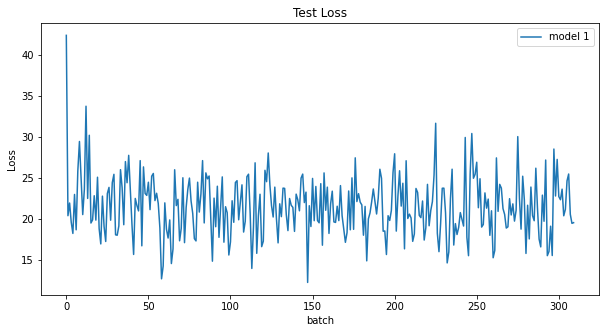


last 10 batch average RMSE = 21.97641955940611


In [18]:
##5
# test loss를 plotting 하기 위한 코드#########
plt.figure(figsize=(10,5))
plt.title("Test Loss")
plt.plot(test_loss_record, label="model 1")
plt.xlabel("batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### <RMSE 평균값 구하는 곳 > (검색용) ################################################################
### 지금은 RMSE 평균값 계산할때, RMSE 값들을 가장 마지막 "10개" 배치만을 이용하도록 되어있음
### 
### RMSE 평균값 계산할때, RMSE 값들을 가장 마지막 "n개" 배치만을 이용하도록 하고 싶으면,
### 아래 코드에서 "-10" 부분을, "-n" 으로 숫자를 바꿔주면 된다. 
#############################################################################################
last_batch_avg_RMSE = sum(test_loss_record[-10:] ,0.0) / len(test_loss_record[-10:])
print("\nlast {} batch average RMSE = {}".format(-(-10) ,last_batch_avg_RMSE))

In [19]:
# <코드 수정 기록> 
# 2021.12.05(일) pm 3
# loss 출력을 RMSE로 바꿈
# 각 배치 마다 test loss 를 리스트로 저장해서, 학습완료후에 학습진행 그래프 출력되도록 코드 추가함
# 평균 RMSE를 계산하기 위해서, 학습중 마지막 10개 배치의 RMSE의 평균값을 출력하도록 코드 추가함
# 2021.12.05(일) pm 6
# 하이퍼파라미터튜닝 할 수 있도록 중요 코드 부분 주석처리함